This notebook contains the implementation of SVM, FFNN, and CNN to Pneumonia data set using SVM with and without PCA 

In [2]:
import os
import numpy as np
import pydicom
import cv2
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


In [3]:
import cv2

In [4]:

# setting paths 
data_dir = '/Users/Lpinheiro/Desktop/MS Data Science/DSP 577/rsna-pneumonia-detection-challenge/pneumonia_data'


In [5]:
train_images_dir = os.path.join(data_dir, 'stage_2_train_images')

In [6]:

train_labels_file = os.path.join(data_dir, 'stage_2_train_labels.csv')


In [7]:

# loading labels 
import pandas as pd
labels = pd.read_csv(train_labels_file)


In [8]:

# labels: 1 = pneumonia, 0 = no pneumonia
labels['Target'] = labels['Target'].apply(lambda x: 1 if x == 1 else 0)
labels = labels[['patientId', 'Target']].drop_duplicates()


In [9]:
# image preprocessing 
# this reduces the images to the desired size
# it does not flatten the images 
def preprocess_images(image_dir, labels_df, img_size):
    images = []
    targets = []
    for _, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
        patient_id = row['patientId']
        target = row['Target']
        image_path = os.path.join(image_dir, f'{patient_id}.dcm')

        # Load and preprocess DICOM image
        try:
            dicom = pydicom.dcmread(image_path)
            img = dicom.pixel_array
            img_resized = cv2.resize(img, (img_size, img_size))
            images.append(img_resized) 
            targets.append(target)
        except Exception as e:
            print(f'Error processing {patient_id}: {e}')

    return np.array(images), np.array(targets)


In [10]:

# PCA
# the function flattens images to a vector as required by PCA
from sklearn.decomposition import PCA


def apply_pca(images, n_components):
    # Flatten each image to 1D (assuming images have shape (samples, height, width, channels))
    n_samples = images.shape[0]
    flattened_images = images.reshape(n_samples, -1)  # Flatten each image to a 1D vector
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_images = pca.fit_transform(flattened_images)
    
    print(f'Dimensionality reduced to {n_components} components.')
    return reduced_images, pca



In [11]:
# t-SNE

from sklearn.manifold import TSNE

def apply_tsne(images, n_components, perplexity=30, random_state=None):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    reduced_images = tsne.fit_transform(images)
    print(f'Dimensionality reduced to {n_components} components using t-SNE.')
    return reduced_images



In [12]:
# Preprocess images
img_size=128


In [13]:
X, y = preprocess_images(image_dir=train_images_dir, labels_df=labels, img_size=img_size)


100%|██████████| 26684/26684 [05:45<00:00, 77.17it/s]


In [14]:

# Apply PCA
X_pca, pca_model = apply_pca(X, n_components=50)


Dimensionality reduced to 50 components.


In [14]:

# Apply t-SNE
X_tsne = apply_tsne(X, n_components=3, perplexity=30, random_state=31415)


Dimensionality reduced to 3 components using t-SNE.


In [21]:

from sklearn.model_selection import train_test_split

In [15]:

# select a subset of 1000 images
# change X to X_pca or X_tsne accordingly 
X_subset, _, y_subset, _ = train_test_split(X_pca, y, 
                                            random_state=42,
                                            stratify=y)


In [16]:
# First, split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=31415, stratify=y_subset
)

# Now, split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=31415, stratify=y_train_val
)
# training, testing, and validation  split

#X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=31415, stratify=y_subset)


In [17]:

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:

import time
import psutil
import torch

start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)
mem_start = psutil.virtual_memory().used

# Original code

# train SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=31415)
svm_model.fit(X_train_scaled, y_train)


# Resource tracking
end_time = time.time()
cpu_end = psutil.cpu_percent(interval=None)
mem_end = psutil.virtual_memory().used

# GPU tracking (if available)
if torch.cuda.is_available():
    gpu_mem = torch.cuda.memory_allocated() / 1024**2
else:
    gpu_mem = "N/A"

print(f"Runtime: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end - cpu_start:.2f}%")
print(f"Memory Used: {(mem_end - mem_start) / 1024**2:.2f} MB")
print(f"GPU Memory Used: {gpu_mem} MB")


Runtime: 9.95 seconds
CPU Usage: 3.10%
Memory Used: 346.75 MB
GPU Memory Used: N/A MB


In [19]:

# evaluate SVM 
y_pred = svm_model.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.7746689982513115
Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3101
           1       0.00      0.00      0.00       902

    accuracy                           0.77      4003
   macro avg       0.39      0.50      0.44      4003
weighted avg       0.60      0.77      0.68      4003



/Users/Lpinheiro/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Lpinheiro/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Lpinheiro/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# Feed Forward Neural Network (FFNN) Implementation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


In [21]:

# FFNN model
ffnn_model = Sequential([
    #Flatten(input_shape=(img_size, img_size)),  # Flatten image data
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])


In [22]:

# compile FFNN model
ffnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:

import time
import psutil
import torch

start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)
mem_start = psutil.virtual_memory().used

# Original code
# fit model 

history= ffnn_model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val))


# Resource tracking
end_time = time.time()
cpu_end = psutil.cpu_percent(interval=None)
mem_end = psutil.virtual_memory().used

# GPU tracking (if available)
if torch.cuda.is_available():
    gpu_mem = torch.cuda.memory_allocated() / 1024**2
    
else:
    gpu_mem = "N/A"

print(f"Runtime: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end - cpu_start:.2f}%")
print(f"Memory Used: {(mem_end - mem_start) / 1024**2:.2f} MB")
print(f"GPU Memory Used: {gpu_mem} MB")


Epoch 1/10
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step - accuracy: 0.7275 - loss: 30.7792 - val_accuracy: 0.6749 - val_loss: 5.5327
Epoch 2/10
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.7586 - loss: 2.9504 - val_accuracy: 0.7542 - val_loss: 0.7691
Epoch 3/10
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.7853 - loss: 0.5363 - val_accuracy: 0.7636 - val_loss: 0.5492
Epoch 4/10
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.7923 - loss: 0.4516 - val_accuracy: 0.7623 - val_loss: 0.6029
Epoch 5/10
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.7921 - loss: 0.4527 - val_accuracy: 0.7914 - val_loss: 0.4893
Epoch 6/10
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.7953 - loss: 0.4350 - val_accuracy: 0.7892 - val_loss: 0.4918
Epoch 7/10
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.7874 - loss: 0.4482 - val_accuracy: 0.7804 - val_loss: 0.4636
Epoch 8/10
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.7899 

In [25]:
mem_end/1024**2


5854.625

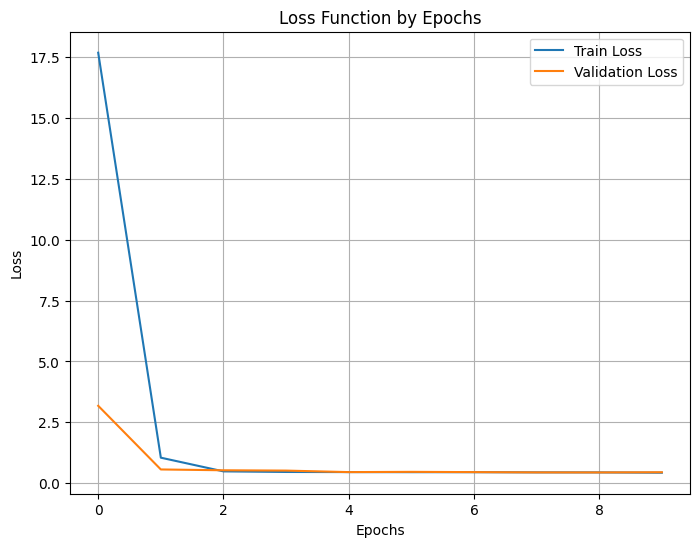

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:

# evaluate FFNN model
ffnn_loss, ffnn_acc = ffnn_model.evaluate(X_test, y_test)
print(f"FFNN Test Accuracy: {ffnn_acc:.2f}")



126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7771 - loss: 0.4606  
FFNN Test Accuracy: 0.78


In [55]:
# CNN model using keras

def build_cnn(img_size):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [53]:

#Example usage:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
CNN = build_cnn(128)


In [56]:
# First, split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=31415, stratify=y
)


In [57]:

# Now, split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=31415, stratify=y_train_val
)


In [ ]:

import time
import psutil
import torch

start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)
mem_start = psutil.virtual_memory().used

# Original code
# This takes 17 minutes or so with 1000 images 
CNN.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


# Resource tracking
end_time = time.time()
cpu_end = psutil.cpu_percent(interval=None)
mem_end = psutil.virtual_memory().used

# GPU tracking (if available)
if torch.cuda.is_available():
    gpu_mem = torch.cuda.memory_allocated() / 1024**2
else:
    gpu_mem = "N/A"

print(f"Runtime: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end - cpu_start:.2f}%")
print(f"Memory Used: {(mem_end - mem_start) / 1024**2:.2f} MB")
print(f"GPU Memory Used: {gpu_mem} MB")


167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step


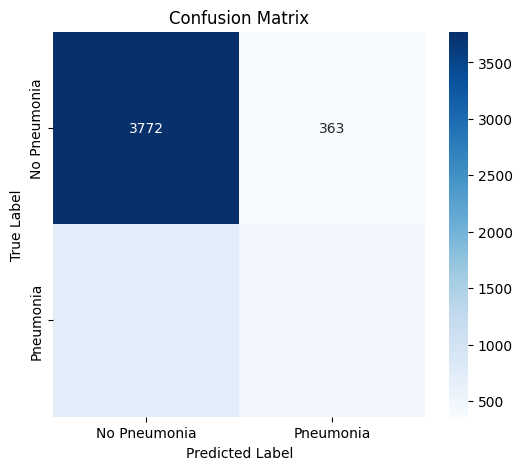

Accuracy: 0.7937043282743114
Classification Report:
               precision    recall  f1-score   support

No Pneumonia       0.84      0.91      0.87      4135
   Pneumonia       0.56      0.39      0.46      1202

    accuracy                           0.79      5337
   macro avg       0.70      0.65      0.67      5337
weighted avg       0.77      0.79      0.78      5337



In [59]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions
y_pred_probs =CNN.predict(X_test)  # Probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pneumonia', 'Pneumonia'], yticklabels=['No Pneumonia', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print performance metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['No Pneumonia', 'Pneumonia']))